![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/healthcare-nlp/09.4.PDF_Deidentification.ipynb)

If you are using the `spark-nlp-jsl` library, please use this  [5.4.Pdf_Deidentification](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/5.4.Pdf_Deidentification.ipynb
) notebook.

### Colab Setup

In [ ]:
# Install the johnsnowlabs library to access Spark-OCR and Spark-NLP for Healthcare, Finance, and Legal.
!pip install -q johnsnowlabs

In [ ]:
from google.colab import files
print('Please Upload your John Snow Labs License using the button below')
license_keys = files.upload()

In [ ]:
from johnsnowlabs import nlp, visual, medical

# After uploading your license run this to install all licensed Python Wheels and pre-download Jars the Spark Session JVM
nlp.install(refresh_install=True, visual=True)

In [4]:
from johnsnowlabs import nlp, visual, medical
import pandas as pd

# Automatically load license data and start a session with all jars user has access to
spark = nlp.start(visual=True)

👌 Detected license file /content/spark_nlp_for_healthcare_spark_ocr_6.0.4.json
👌 Launched cpu optimized session with with: 🚀Spark-NLP==6.0.4, 💊Spark-Healthcare==6.0.4, 🕶Spark-OCR==6.0.0, running on ⚡ PySpark==3.4.0


In [16]:
import pkg_resources
from pyspark.ml import PipelineModel
from pyspark.sql import functions as F
from sparkocr.transformers import *
from pyspark.ml import PipelineModel
from sparkocr.utils import display_image
from sparkocr.metrics import score

## Define de-identification  NLP pipeline

In [9]:
def deidentification_nlp_pipeline(input_column, prefix = "", model="ner_deid_large"):
    document_assembler = nlp.DocumentAssembler() \
        .setInputCol(input_column) \
        .setOutputCol(prefix + "document_raw")

    cleanUpPatterns = ["<[^>]>"]
    documentNormalizer = nlp.DocumentNormalizer() \
      .setInputCols(prefix + "document_raw") \
      .setOutputCol(prefix + "document") \
      .setAction("clean") \
      .setPatterns(cleanUpPatterns) \
      .setReplacement(" ") \
      .setPolicy("pretty_all")

    # Sentence Detector annotator, processes various sentences per line
    sentence_detector = nlp.SentenceDetector() \
        .setInputCols([prefix + "document"]) \
        .setOutputCol(prefix + "sentence")

    tokenizer = nlp.Tokenizer() \
        .setInputCols([prefix + "sentence"]) \
        .setOutputCol(prefix + "token")

    # Clinical word embeddings
    word_embeddings = nlp.WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models") \
        .setInputCols([prefix + "sentence", prefix + "token"]) \
        .setOutputCol(prefix + "embeddings") \
        .setEnableInMemoryStorage(True)

    clinical_ner = medical.NerModel.pretrained(model, "en", "clinical/models") \
        .setInputCols([prefix + "sentence", prefix + "token", prefix + "embeddings"]) \
        .setOutputCol(prefix + "ner")

    custom_ner_converter = nlp.NerConverter() \
        .setInputCols([prefix + "sentence", prefix + "token", prefix + "ner"]) \
        .setOutputCol(prefix + "ner_chunk") \
        .setWhiteList(['NAME', 'AGE', 'CONTACT', 'ID',
                   'LOCATION', 'PROFESSION', 'PERSON', 'DATE', 'DOCTOR'])

    nlp_pipeline = nlp.Pipeline(stages=[
            document_assembler,
            documentNormalizer,
            sentence_detector,
            tokenizer,
            word_embeddings,
            clinical_ner,
            custom_ner_converter
        ])
    empty_data = spark.createDataFrame([[""]]).toDF(input_column)
    nlp_model = nlp_pipeline.fit(empty_data)
    return nlp_model

## Define OCR transformers and pipeline for image deidentification

In [23]:
pdf_to_image = visual.PdfToImage() \
    .setInputCol("content") \
    .setOutputCol("image") \
    .setPartitionNum(16)\
    .setSplitNumBatch(2)\
    .setPartitionNumAfterSplit(2) \
    .setSplittingStategy(visual.SplittingStrategy.FIXED_NUMBER_OF_PARTITIONS) \
    .setKeepInput(False)

ocr = visual.ImageToText() \
    .setInputCol("image") \
    .setOutputCol("text") \
    .setIgnoreResolution(False) \
    .setPageIteratorLevel(visual.PageIteratorLevel.SYMBOL) \
    .setPageSegMode(visual.PageSegmentationMode.SPARSE_TEXT) \
    .setConfidenceThreshold(70)

# Found coordinates of sensitive data
position_finder = visual.PositionFinder() \
    .setInputCols(["ner_chunk"]) \
    .setOutputCol("regions") \
    .setPageMatrixCol("positions") \
    .setIgnoreSchema(True) \
    .setOcrScaleFactor(1.0)

#Draw filled rectangle for hide sensitive data
draw_regions = visual.ImageDrawRegions() \
    .setInputCol("image") \
    .setInputRegionsCol("regions") \
    .setOutputCol("cleaned_images") \
    .setFilledRect(True)

image_to_pdf = visual.ImageToPdf() \
    .setInputCol("cleaned_images") \
    .setOutputCol("pdf")

# OCR pipeline
pipeline = nlp.PipelineModel(stages=[
    pdf_to_image,
    ocr,
    deidentification_nlp_pipeline(input_column="text", prefix="", model="ner_deid_generic_augmented"),
    position_finder,
    draw_regions
])

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_deid_generic_augmented download started this may take some time.
[OK!]


## Read PDF file and display it

Optimized for multipage PDF processing

In [24]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Healthcare/data/ocr/MT_00_compressed.pdf -P /content/deid/


    Image #0:
    Origin: file:/content/deid/MT_00_compressed.pdf
    Resolution: 100 dpi
    Width: 750 px
    Height: 1083 px
    Mode: 10
    Number of channels: 1


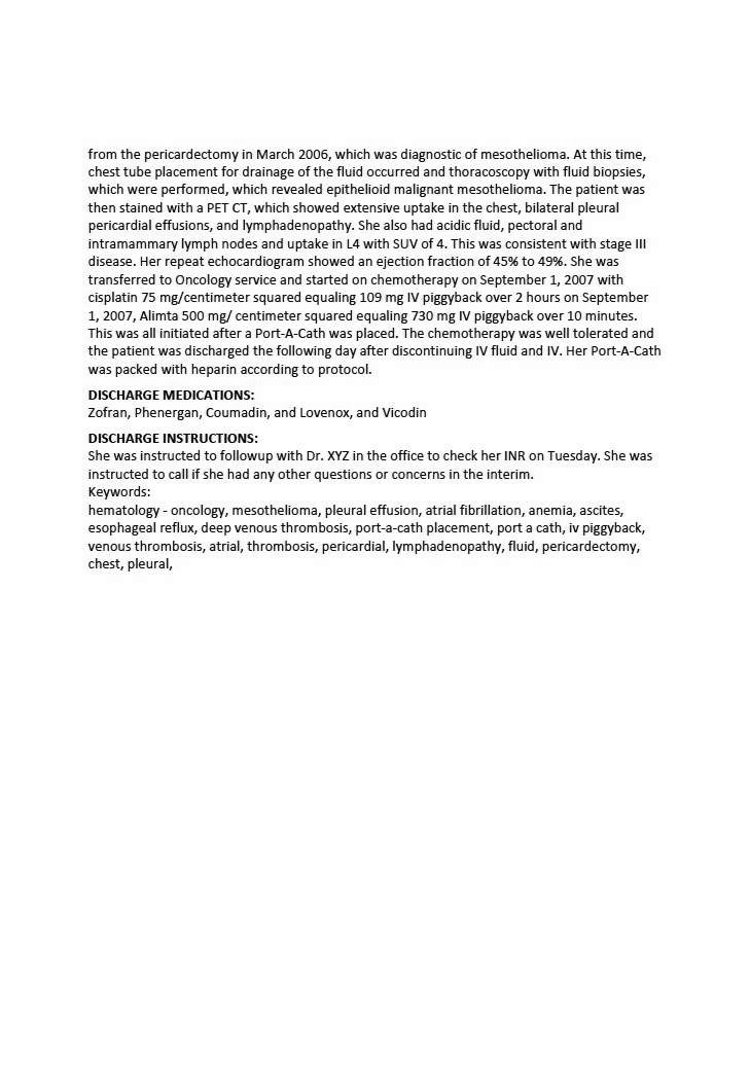


    Image #1:
    Origin: file:/content/deid/MT_00_compressed.pdf
    Resolution: 100 dpi
    Width: 750 px
    Height: 1083 px
    Mode: 10
    Number of channels: 1


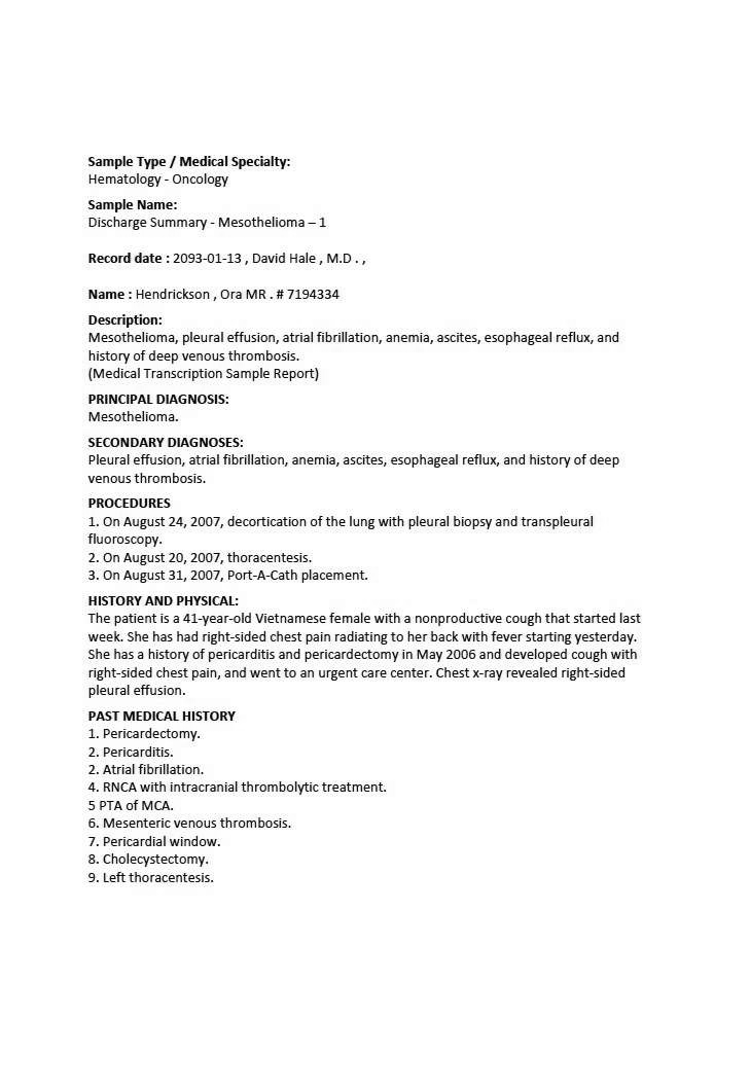


    Image #2:
    Origin: file:/content/deid/MT_00_compressed.pdf
    Resolution: 100 dpi
    Width: 750 px
    Height: 1083 px
    Mode: 10
    Number of channels: 1


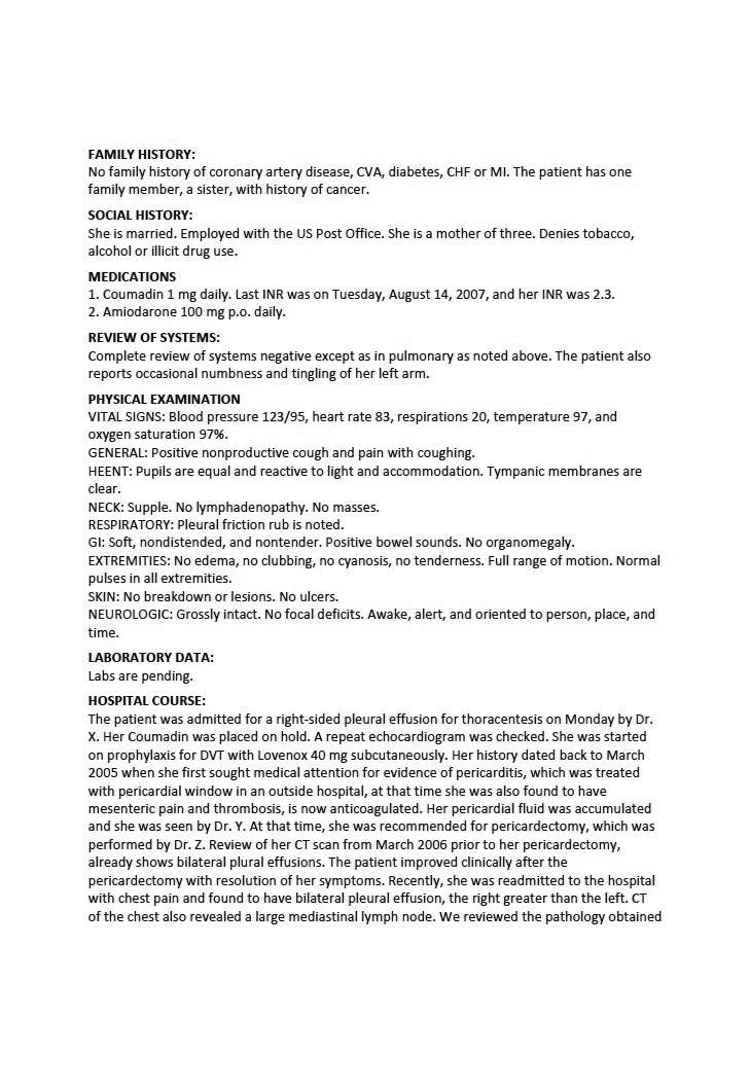

In [25]:
file_path='/content/deid/*.pdf'
pdf_df = spark.read.format("binaryFile").load(file_path)
visual.display_images(pdf_to_image.setResolution(100).transform(pdf_df))

## Run de-id pipeline

In [20]:
from pyspark.sql.types import StringType

In [26]:
%%time

OUTPUT_PATH = "./de-id/"

def get_name(path, keep_subfolder_level=0):
    path = path.split("/")
    path[-1] = ".".join(path[-1].split('.')[:-1])
    return "/".join(path[-keep_subfolder_level-1:])


pages = pipeline.transform(pdf_df) \
    .cache() \
    .orderBy("pagenum")

image_to_pdf.transform(pages) \
    .withColumn("fileName", F.udf(get_name, StringType())(F.col("path"))) \
    .write \
    .format("binaryFormat") \
    .option("type", "pdf") \
    .option("field", "pdf") \
    .option("nameField", "fileName") \
    .option("extension", "pdf") \
    .option("prefix", "") \
    .mode("append") \
    .save(OUTPUT_PATH)

CPU times: user 91.8 ms, sys: 37.1 ms, total: 129 ms
Wall time: 1min 11s


## Check results

In [27]:
%%bash
ls ./de-id

MT_00_compressed.pdf
_SUCCESS



    Image #0:
    Origin: file:/content/de-id/MT_00_compressed.pdf
    Resolution: 100 dpi
    Width: 700 px
    Height: 999 px
    Mode: 10
    Number of channels: 1


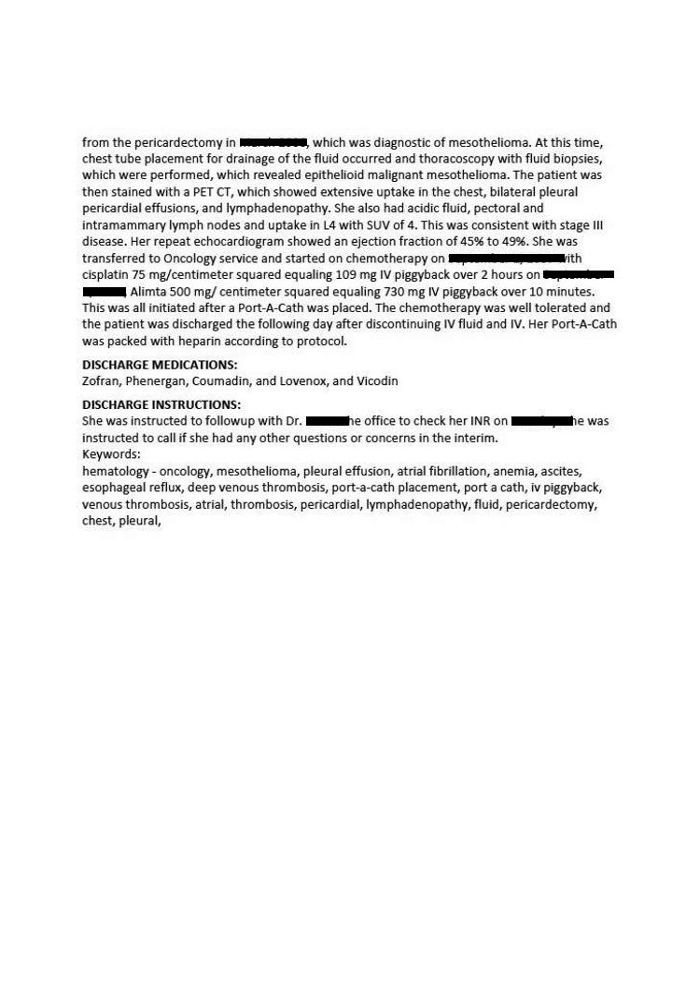


    Image #1:
    Origin: file:/content/de-id/MT_00_compressed.pdf
    Resolution: 100 dpi
    Width: 700 px
    Height: 999 px
    Mode: 10
    Number of channels: 1


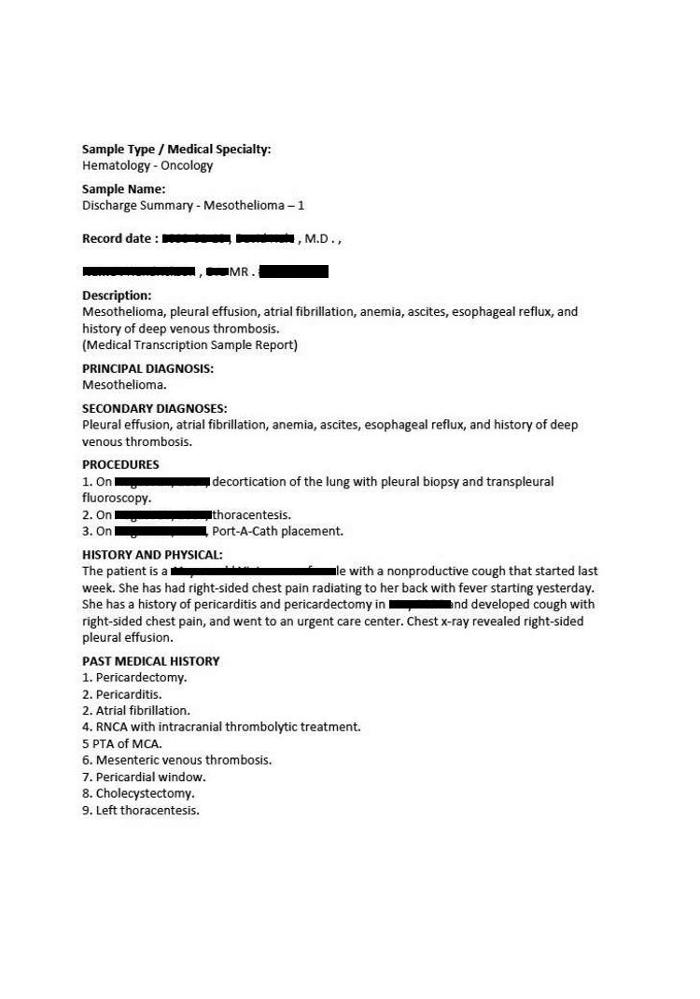


    Image #2:
    Origin: file:/content/de-id/MT_00_compressed.pdf
    Resolution: 100 dpi
    Width: 700 px
    Height: 999 px
    Mode: 10
    Number of channels: 1


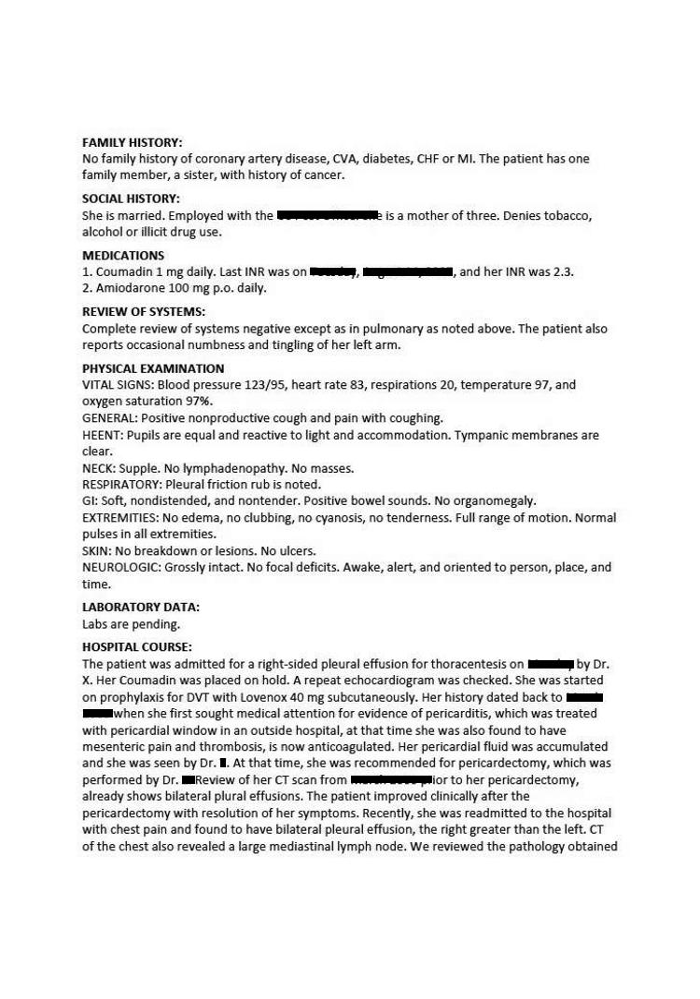

In [28]:
result_pdf_df = spark.read.format("binaryFile").load("./de-id/MT_00_compressed.pdf")
#display_pdf(result_pdf_df)
visual.display_images(pdf_to_image.setResolution(100).transform(result_pdf_df))